In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import timm

import random


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2

In [2]:
from mlops_lukianenko import dataset

2025-01-04 16:32:42.731 | INFO     | mlops_lukianenko.config:<module>:11 - PROJ_ROOT path is: C:\workV\.Maga\3sem\RO\LAB5\MLOps\mlops


In [3]:
# Использование GPU по желанию

if torch.cuda.is_available():
  device = torch.device('cuda')
  print('Работаем на GPU')
else:
  device = torch.device('cpu')
  print('Работаем на CPU')


Работаем на GPU


In [4]:
data_dir = './dataset'

In [5]:
transform_pipeline = dataset.get_transforms_pipeline()

In [6]:
train_dataset, test_dataset = dataset.get_datasets(data_dir, transform_pipeline)

In [7]:
# Создаем DataLoader
train_loader, test_loader = dataset.get_loaders(train_dataset, test_dataset)

In [8]:
print("Данные разделены и подготовлены.")

Данные разделены и подготовлены.


In [9]:
from mlops_lukianenko import plots

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5005665].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5528543].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.535425].
Clipping

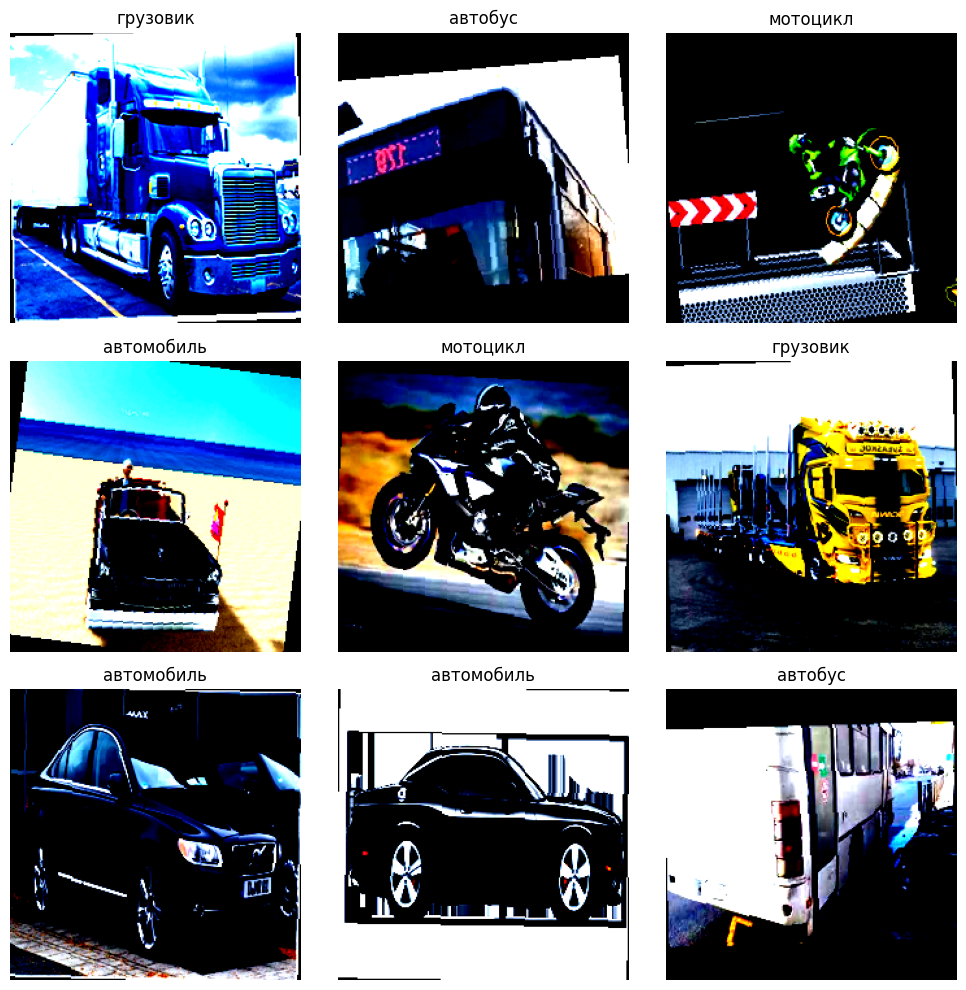

In [12]:
plots.show_random_classes(train_dataset,3)

In [ ]:
model_name = "resnet50"  # Выбранная модель
pretrained_model = timm.create_model(model_name, pretrained=True)

